# Class 22: Hypothesis tests continued

Plan for today:
- Hypothesis tests assessing causality  
- Confidence intervals


## Notes on the class Jupyter setup

If you have the *ydata123_2023e* environment set up correctly, you can get the class code using the code below (which presumably you've already done given that you are seeing this notebook).  

In [20]:
import YData

# YData.download.download_class_code(22)   # get class code    
# YData.download.download_class_code(22, TRUE) # get the code with the answers 

YData.download_data("bta.csv")
YData.download_data("movies.csv")

The file `bta.csv` already exists.
If you would like to download a new copy of the file, please rename the existing copy of the file.
The file `movies.csv` already exists.
If you would like to download a new copy of the file, please rename the existing copy of the file.


There are also similar functions to download the homework:

In [21]:
# YData.download.download_homework(8)  # downloads the homework 

If you are using colabs, you should install the YData packages by uncommenting and running the code below.

In [22]:
# !pip install https://github.com/emeyers/YData_package/tarball/master

If you are using google colabs, you should also uncomment and run the code below to mount the your google drive

In [23]:
# from google.colab import drive
# drive.mount('/content/drive')

In [24]:
import statistics
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from urllib.request import urlopen

import matplotlib.pyplot as plt
%matplotlib inline

## Hypothesis tests

In hypothesis testing, we start with a claim about a population parameter (e.g., µ = 4.2, or π = 0.25).

This claim implies we should get a certain distribution of statistics, called "The null distribution". 

If our observed statistic is highly unlikely to come from the null distribution, we reject the claim. 

We can break down the process of running a hypothesis test into 5 steps. 

1. State the null and alternative hypothesis
2. Calculate the observed statistic of interest
3. Create the null distribution 
4. Calculate the p-value 
5. Make a decision

Let's run through these steps now!


## 1. Hypothesis test assessing causal relationships

To get at causality we can run a Randomized Controlled Trial (RTC), where have of the participants are randomly assigned to a "treatment group" that receives an intervention and the other half of participants are put in a "control group" which receives a placebo. If the treatment group shows a an improvement over the control group that is larger than what is expected by chance, this indicates that the treatment **causes** an improvement. 


#### Botulinum Toxin A (BTA) as a treatment to chronic back pain

A study by Foster et al (2001) examined whether Botulinum Toxin A (BTA) was an effective treatment for chronic back pain.

In the study, participants were randomly assigned to be in a treatment or control group: 
- 15 in the treatment group
- 16 in the control group (normal saline)

Trials were run double-blind (neither doctors nor patients knew which group they were in)

Result from the study were coded as:
  - 1 indicates pain relief
  - 0 indicates lack of pain relief 


Let's run a hypothesis test to see if BTA causes a decrease in back pain.

### Step 1: State the null and alternative hypotheses


$H_0$: $\pi_{treat} =  \pi_{control}$   or    $H_0$: $\pi_{treat} -  \pi_{control} = 0$ 

$H_A$: $\pi_{control} < \pi_{treat}$    or    $H_0$: $\pi_{treat} -  \pi_{control} < 0$ 



Where $\pi_{treat}$ and $\pi_{control}$ and the population proportions of people who experienced back pain relief after receiving the BTA or control respectively. 


### Step 2: Calculate the observed statistic

The code below loads the data from the study. We can use the difference in proportions  $\hat{p}_{treat} - \hat{p}_{control}$  as our observed statistic. 

Let's calculate the observe statistic and save it to the name `obs_stat`.


In [25]:
bta = pd.read_csv('bta.csv')
bta.sample(frac = 1)

,Group,Result
18,Treatment,1.0
5,Control,0.0
24,Treatment,1.0
12,Control,0.0
25,Treatment,0.0
19,Treatment,1.0
10,Control,0.0
22,Treatment,1.0
27,Treatment,0.0
21,Treatment,1.0


In [26]:
# create a DataFrame with the proportion of people in the treatment and control groups that have pain relief 

results_table = bta.groupby("Group").mean()

results_table

,Result
Group,
Control,0.125
Treatment,0.600


In [27]:
# calculate the observed statistic from our DataFrame

obs_stat = results_table["Result"][1] - results_table["Result"][0]

obs_stat

0.475

In [28]:
# let's write a function to make it easy to get statistic values

def get_prop_diff(bta_data):
    
    group_means = bta_data.groupby("Group").mean()
    
    return group_means["Result"][1] - group_means["Result"][0]

    
get_prop_diff(bta)


0.475

### Step 3: Create the null distribution 

To create the null distribution, we need to create statistics consistent with the null hypothesis. 

In this example, if the null hypothesis was true, then there would be no difference between the treatment and control group. Thus, under the null hypothesis, we can shuffle the group labels and get equally valid statistics. 

Let's create one statistic consistent with the null distribution to understand the process. We can then repeat this 10,000 times to get a full null distribution. 

In [29]:
# shuffle the data 

shuff_bta = bta.copy()
shuff_bta['Group'] = np.random.permutation(bta["Group"])

shuff_bta.head()


,Group,Result
0,Control,1.0
1,Control,1.0
2,Control,0.0
3,Control,0.0
4,Treatment,0.0


In [30]:
# get one statistic consistent with the null distribution 

get_prop_diff(shuff_bta)

0.08750000000000002

In [31]:
%%time

# create a full null distribution 

null_dist = []

for i in range(10000):
    
    shuff_bta['Group'] = np.random.permutation(bta["Group"])
    
    shuff_stat = get_prop_diff(shuff_bta)
    
    null_dist.append(shuff_stat)


CPU times: user 7.51 s, sys: 70.1 ms, total: 7.58 s
Wall time: 7.69 s


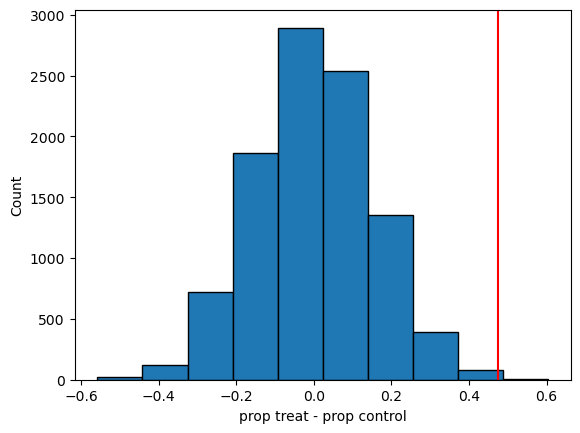

In [32]:
# visualize the null distribution 

plt.hist(null_dist, edgecolor = "black");


# put a line at the observed statistic value

plt.axvline(obs_stat, color = "red");
plt.xlabel("prop treat - prop control");
plt.ylabel("Count");

### Step 4: Calculate the p-value

The p-value is the proportion of points in the null distribution that are more extreme than the observed statistic. 


In [33]:
p_value = np.mean(np.array(null_dist) >= obs_stat)

p_value

0.0089

### Step 5: Draw a conclusion

Since the p-value is less than the typical significance level of 0.05, we can reject the null hypothesis and conclude that BTA does **cause** pain relief at a higher rate than the placebo. 

## 2. Using hypothesis tests to generate confidence intervals

There are several methods we that can be used to calculate confidence intervals, including using a computational method called the "bootstrap" and using "parametric methods" that involve using probability distributions. If you take a traditional introductory statistics class you will learn some of these methods.

Below we use a less conventional method to calculate confidence intervals by looking at all parameters values that a hypothesis test fails to reject (at the p-value < 0.05 level). As you will see, the method gives similar results to other methods, although it requires a bit more computation time.

As an example, let's create a confidence interval for the population proportion of movies $\pi$ that pass the Bechdel test. As is the case for all confidence intervals, this confidence interval gives a range of plausible values that likely contains the true population proportion $\pi$.


In [34]:
# To start, let's use a function that generates a statistic p-hat that is consistent with a particular population parameter value pi

def generate_prop_bechdel(n, null_prop):
    
    random_sample = np.random.rand(n) <= null_prop
    return np.mean(random_sample)

generate_prop_bechdel(1794, .5)


0.4921962095875139

In [35]:
# The function below calculates a p-value for the Bechdel data based on a particular pi value that is specified in a null hypothesis.
# (i.e., it is a function that encapsulates the hypothesis test you ran in class 20).


def get_Bechdel_pvalue(null_hypothesis_pi, plot_null_dist = False):
    
    
    # The observed p-hat value
    prop_passed = 803/1794
    
    
    # Generate the null distribution 
    null_dist = []
    
    for i in range(10000):    
        null_dist.append(generate_prop_bechdel(1794, null_hypothesis_pi))
    
    
    # Calculate a "two-tailed" p-value which is the proportion of statistcs more extreme than the observed statistic
    
    statistic_deviation = np.abs(null_hypothesis_pi - prop_passed)
    
    pval_left = np.mean(np.array(null_dist) <= null_hypothesis_pi - statistic_deviation)
    pval_right = np.mean(np.array(null_dist) >= null_hypothesis_pi + statistic_deviation)
    
    p_value = pval_left + pval_right

    
    # plot the null distribution and lines indicating values more extreme than the observed statistic 
    if plot_null_dist:
        
        plt.hist(null_dist, edgecolor = "black", bins = 30);
        plt.axvline(null_hypothesis_pi - statistic_deviation, color = "red");
        plt.axvline(null_hypothesis_pi + statistic_deviation, color = "red");
        plt.axvline(null_hypothesis_pi, color = "yellow");

        
        plt.title("Pi-null is: " + str(null_hypothesis_pi) + "      "  +
                  "p-value is: " + str(round(p_value, 5)))
      
    # return the p-value
    return p_value
    


0.8469

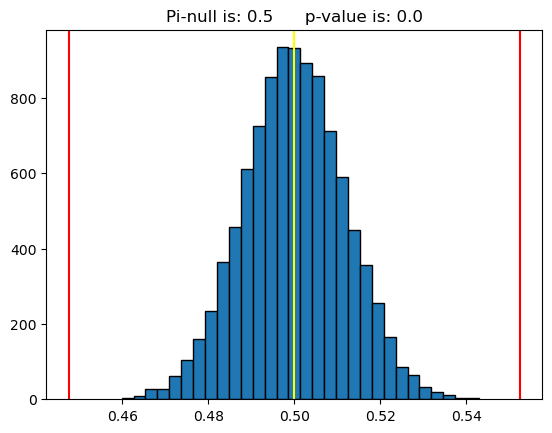

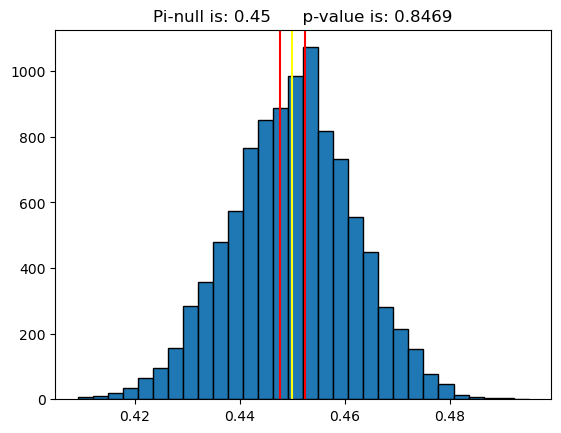

In [36]:
# test the function with the value H0: pi = .5  (as we did in class 20)
get_Bechdel_pvalue(.5, True)


# test the function with the value H0: pi = .45
plt.figure()
get_Bechdel_pvalue(.45, True)

In [37]:
# create a range range of H0: pi = x  values

possible_null_pis = np.round(np.arange(.4, .5, .005), 5)

possible_null_pis    


array([0.4  , 0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 ,
       0.445, 0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485,
       0.49 , 0.495])

In [38]:
%%time


# get the p-value for a range of H0: pi = x  values


pvalues = []

for null_pi in possible_null_pis:
    
    curr_pvalue = get_Bechdel_pvalue(null_pi)
    
    pvalues.append(curr_pvalue)



CPU times: user 5.56 s, sys: 21.4 ms, total: 5.58 s
Wall time: 5.67 s


In [39]:
# view the p-values 
# convention calls a p-value < 0.05 is "statistically significant" indicating a pi imcompatible with the null hypothesis
# our confidence interval is all pi values that are not statistically significant (i.e., pi values that are consistent with particular H0)

pvalue_df = pd.DataFrame({"pi": possible_null_pis, 
                          "p-values": pvalues,
                          "non-significant": np.array(pvalues) > .05})

pvalue_df


,pi,p-values,non-significant
0,0.400,0.0001,False
1,0.405,0.0005,False
2,0.410,0.0018,False
3,0.415,0.0050,False
4,0.420,0.0195,False
5,0.425,0.0573,True
6,0.430,0.1365,True
7,0.435,0.2887,True
8,0.440,0.5055,True
9,0.445,0.8310,True


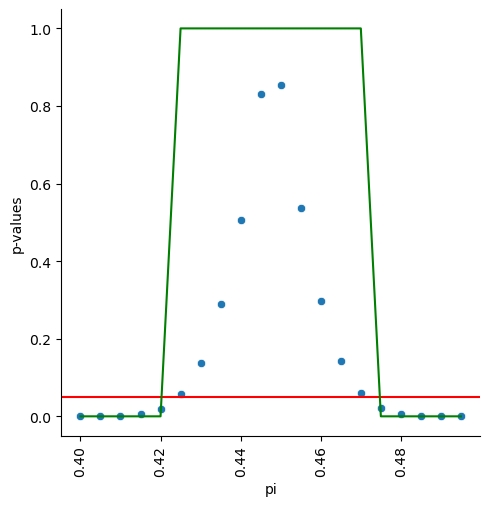

In [40]:
# plot p-values as as function of H0 pi's

sns.relplot(pvalue_df, x = 'pi', y = 'p-values');
plt.xticks(rotation=90);
plt.axhline(.05, color = "red");

plt.plot(pvalue_df['pi'], pvalue_df['non-significant'], color = "green");


In [41]:
# Get all plausible Pi values
fail_to_reject_pis = possible_null_pis[np.array(pvalues) >= .05]

fail_to_reject_pis

array([0.425, 0.43 , 0.435, 0.44 , 0.445, 0.45 , 0.455, 0.46 , 0.465,
       0.47 ])

In [42]:
# get the CI as the max and min plausible pi values 

(min(fail_to_reject_pis), max(fail_to_reject_pis))


(0.425, 0.47)

In [43]:
# using the statsmodels package to compute a confidence interval for a proportion

import statsmodels.api as sm

ci_low, ci_upp = sm.stats.proportion_confint(803, 1794, alpha=0.05, method='normal')
(round(ci_low, 3), round(ci_upp, 3))


(0.425, 0.471)